---

### Load Libraries and Dataset

---

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.preprocessing import StandardScaler

In [ ]:
lifex = pd.read_csv('https://richardson.byu.edu/220/life_expectancy.csv')

---

### Exploratory Data Analysis

---

In [ ]:
print(lifex.shape)
lifex.head()

(1649, 16)


,Country,Year,Status,Life_Expectancy,Alcohol,health_expenditure,HepB,Measles,BMI,Polio,Diphtheria,HIV,GDP,Population,HDI,Schooling
0,Afghanistan,2015,Developing,65.0,0.01,71.279624,65,1154,19.1,6,65,0.1,584.259210,33736494.0,0.479,10.1
1,Afghanistan,2014,Developing,59.9,0.01,73.523582,62,492,18.6,58,62,0.1,612.696514,327582.0,0.476,10.0
2,Afghanistan,2013,Developing,59.9,0.01,73.219243,64,430,18.1,62,64,0.1,631.744976,31731688.0,0.470,9.9
3,Afghanistan,2012,Developing,59.5,0.01,78.184215,67,2787,17.6,67,67,0.1,669.959000,3696958.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,0.01,7.097109,68,3013,17.2,68,68,0.1,63.537231,2978599.0,0.454,9.5


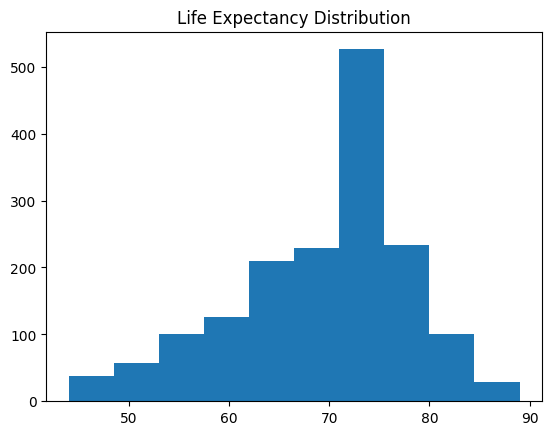

In [ ]:
_ = plt.hist(lifex.Life_Expectancy)
_ = plt.title("Life Expectancy Distribution")

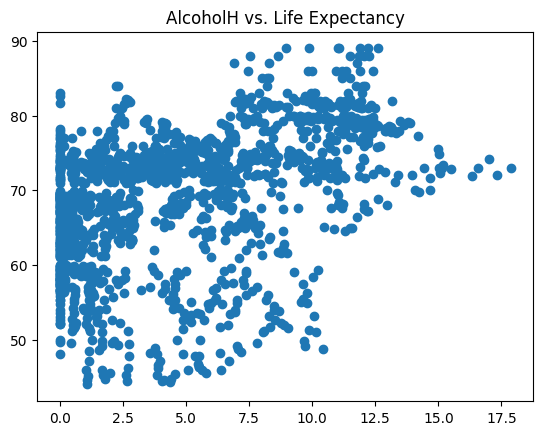

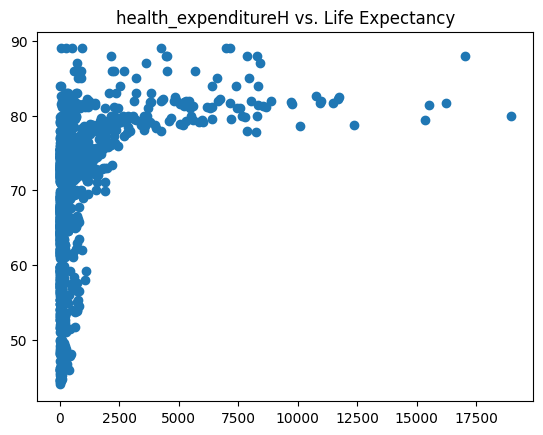

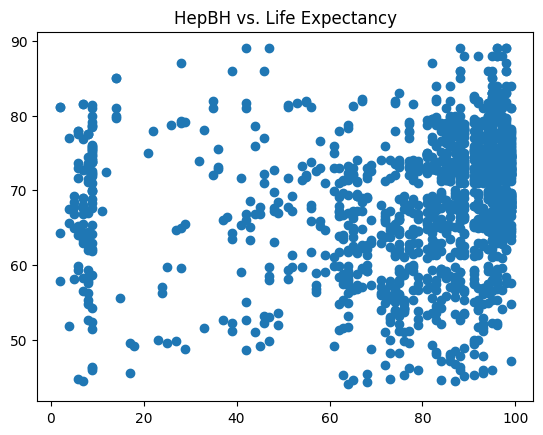

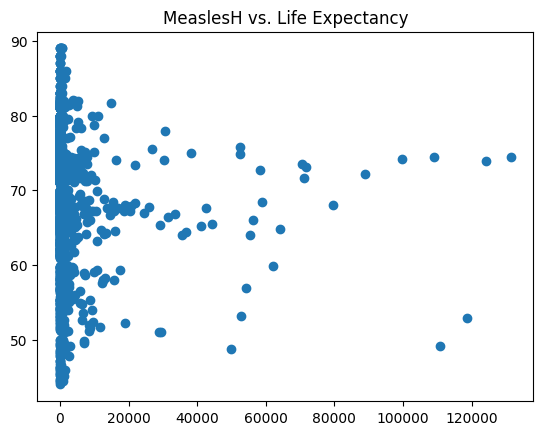

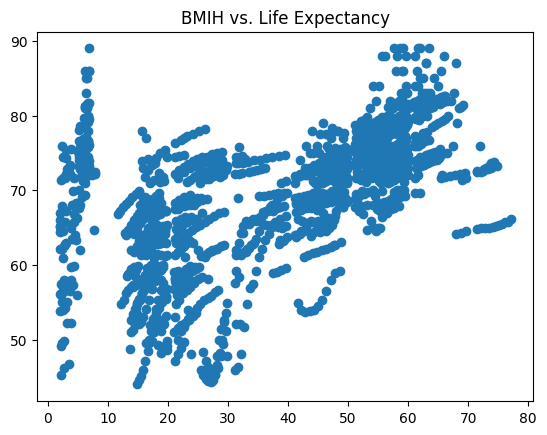

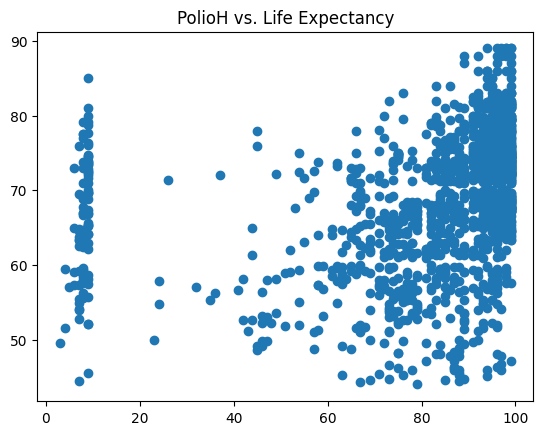

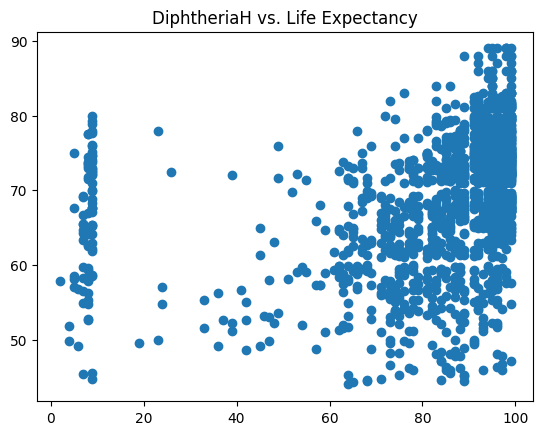

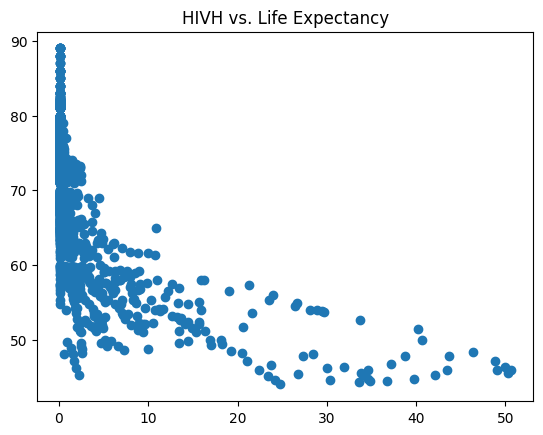

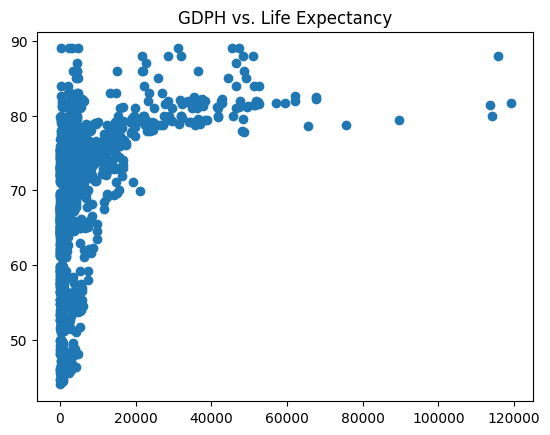

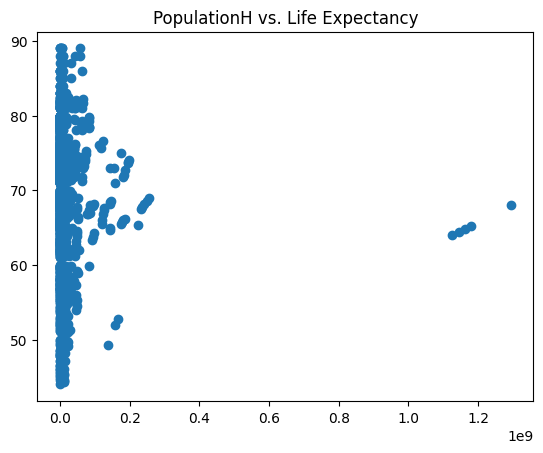

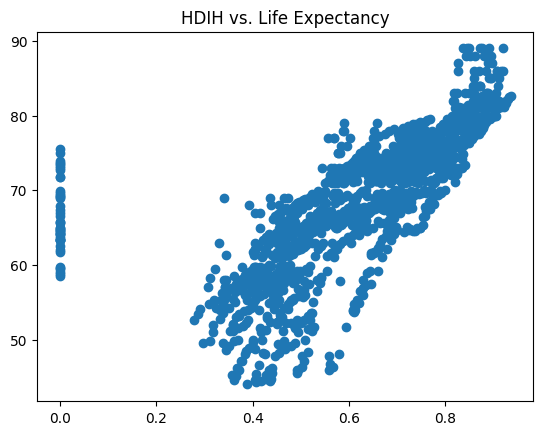

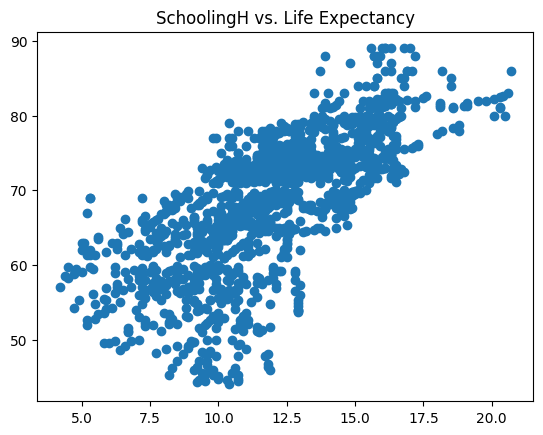

69.3023044269254


In [ ]:
# Visualize all predictors vs. target
columns = lifex.columns
ignore = ["Country",	"Year",	"Status", "Life_Expectancy"]
for i in range(len(columns)):
  if columns[i] not in ignore:
    _ = plt.scatter(lifex[columns[i]], lifex.Life_Expectancy)
    _ = plt.title(columns[i]+"H vs. Life Expectancy")
    _ = plt.show()

print(np.mean(lifex.Life_Expectancy))

---

### Linear Regression Model

---

In [ ]:
# Get dummy variables
pred_dum = pd.get_dummies(lifex.drop(columns=['Country', 'Year', 'Life_Expectancy']), drop_first=True)
y = np.array(lifex.Life_Expectancy).reshape(-1,1)

# Scale target
y_scaler = StandardScaler()
y_scaler.fit(y)
y_scaled = y_scaler.transform(y)

# Get all higher order terms
poly = PolynomialFeatures(2)
X_hot = poly.fit_transform(pred_dum)
hot_names = poly.get_feature_names_out(pred_dum.columns)
X_full = pd.DataFrame(sm.add_constant(X_hot),columns = hot_names)
X_ready = X_full.T.drop_duplicates().T

# Get train-test split
X_train, X_test, y_train, y_test = train_test_split(X_ready, y_scaled, test_size=0.2, random_state=1234)

# Remove higher-order terms with nan p-values
mod_full = sm.OLS(y_train,X_train).fit()
all_nan = np.isnan(mod_full.pvalues)
X_train = X_train.loc[:,~all_nan]
X_test = X_test.loc[:,~all_nan]

In [ ]:
mod_temp = sm.OLS(y_train,X_train).fit()

while max(mod_temp.pvalues) > 0.05 and (len(X_train.columns) > 1):
  max_pvalue = np.argmax(mod_temp.pvalues[1:])+1
  z = X_train.columns[max_pvalue]
  X_train = X_train.drop(columns = z)
  X_test = X_test.drop(columns = z)
  mod_temp = sm.OLS(y_train,X_train).fit()

mod_reduced = mod_temp

# mod_reduced.summary()

In [ ]:
train_preds = mod_reduced.predict(X_train)
test_preds = mod_reduced.predict(X_test)
y_std, y_bar = np.std(y), np.mean(y)

print("In Sample R^2:  ",r2_score(y_train,train_preds))
print("In Sample MSE:  ",mean_squared_error(y_train,train_preds) * y_std)
print("\nOut Sample R^2: ",r2_score(y_test,test_preds))
print("Out Sample MSE: ",mean_squared_error(y_test,test_preds) * y_std)

In Sample R^2:   0.8945082764919733
In Sample MSE:   0.9313024702210476

Out Sample R^2:  0.8853184148580332
Out Sample MSE:  0.9891960383600781


Scaling the target variable, Life_Expectancy resulted in a 0.01-unit increase in both in-sample and out-sample R^2 scores.

In [ ]:
# Get feature importances
mod_reduced.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.895
Model:                            OLS   Adj. R-squared:                  0.892
Method:                 Least Squares   F-statistic:                     302.0
Date:                Mon, 17 Apr 2023   Prob (F-statistic):               0.00
Time:                        17:10:36   Log-Likelihood:                -390.83
No. Observations:                1319   AIC:                             855.7
Df Residuals:                    1282   BIC:                             1047.
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
1                              -2.5162      0.167    -15.072      0.000      -2.844      -2.189
Alcohol                        -0.1686      0.020     -8.477      0.000      -0.208      -0.130
health_expenditure              0.0007      0.000      4.682      0.000       0.000       0.001
BMI                             0.0192      0.004      4.938      0.000       0.012       0.027
HIV                            -0.0391      0.016     -2.469      0.014      -0.070      -0.008
Schooling                       0.1180      0.032      3.652      0.000       0.055       0.181
Alcohol^2                      -0.0077      0.001    -10.238      0.000      -0.009      -0.006
Alcohol HIV                     0.0062      0.001      5.049      0.000       0.004       0.009
Alcohol Population          -1.482e-10    7.5e-11     -1.974      0.049   -2.95e-10   -9.38e-13
Alcohol HDI                    -0.0818      0.041     -1.986      0.047      -0.163      -0.001
Alcohol Schooling               0.0214      0.002      9.797      0.000       0.017       0.026
health_expenditure^2        -2.265e-08   4.53e-09     -5.002      0.000   -3.15e-08   -1.38e-08
health_expenditure Polio      4.43e-06   8.31e-07      5.329      0.000     2.8e-06    6.06e-06
health_expenditure HDI         -0.0010      0.000     -4.639      0.000      -0.001      -0.001
Measles Polio                1.477e-07   7.34e-08      2.013      0.044    3.73e-09    2.92e-07
Measles HIV                  1.029e-06   4.97e-07      2.071      0.039     5.4e-08       2e-06
Measles HDI                  7.978e-05   2.78e-05      2.872      0.004    2.53e-05       0.000
Measles Schooling           -5.569e-06   1.45e-06     -3.829      0.000   -8.42e-06   -2.72e-06
BMI^2                        9.891e-05   3.39e-05      2.920      0.004    3.25e-05       0.000
BMI Diphtheria              -8.638e-05   2.72e-05     -3.178      0.002      -0.000    -3.3e-05
BMI GDP                      2.361e-07   5.79e-08      4.080      0.000    1.23e-07     3.5e-07
BMI HDI                         0.0117      0.004      2.712      0.007       0.003       0.020
BMI Schooling                  -0.0020      0.000     -6.386      0.000      -0.003      -0.001
Polio^2                      7.855e-05   1.42e-05      5.527      0.000    5.07e-05       0.000
Polio GDP                   -7.613e-07   1.24e-07     -6.158      0.000      -1e-06   -5.19e-07
Polio Schooling                -0.0006      0.000     -4.218      0.000      -0.001      -0.000
Diphtheria HIV                 -0.0002   7.23e-05     -2.239      0.025      -0.000      -2e-05
Diphtheria Population        6.969e-12   3.13e-12      2.228      0.026    8.34e-13    1.31e-11
Diphtheria HDI                  0.0070      0.002      3.738      0.000       0.003       0.011
HIV^2      

---

### Regression Tree Model

---

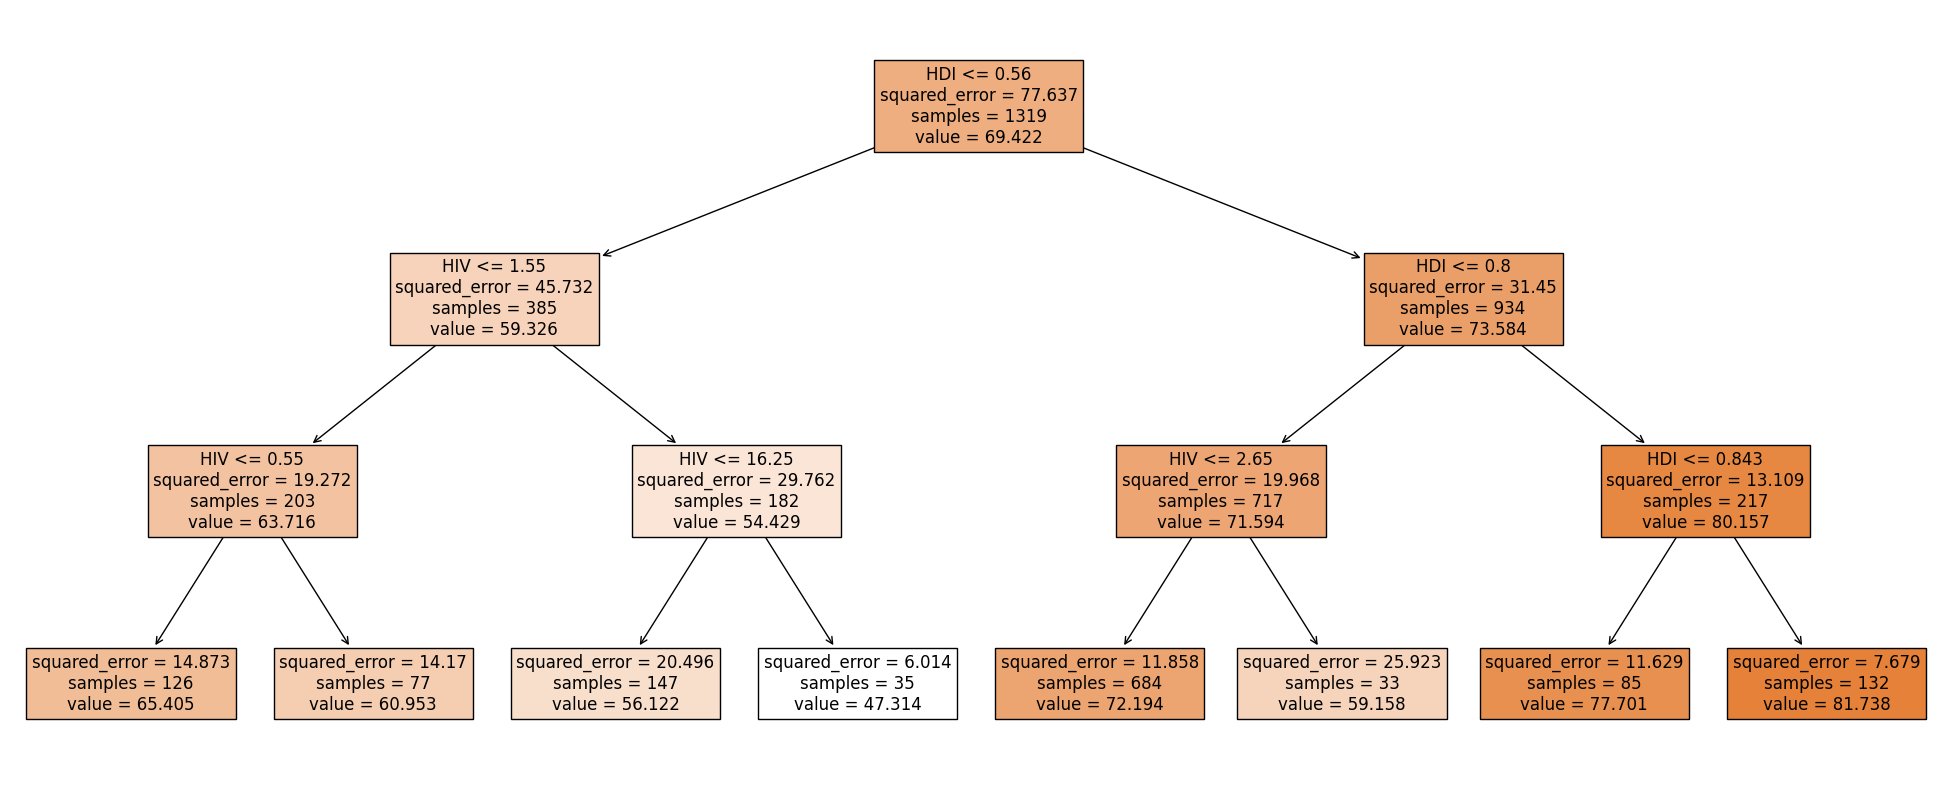

In [ ]:
# split into train/test groups
X_tree = pd.get_dummies(lifex.drop(columns=["Country", "Year", "Life_Expectancy"]), drop_first=True)
y_tree = lifex.Life_Expectancy

X_train_tree, X_test_tree, y_train_tree, y_test_tree = train_test_split(X_tree, y_tree, test_size=0.2, random_state=1234)

#Create a tree with 3 layers
tree_prep = DecisionTreeRegressor(max_depth = 3)
mod_tree = tree_prep.fit(X_train_tree,y_train_tree)
_ = plt.figure(figsize = (25,10))
_ = tree.plot_tree(mod_tree, feature_names=X_tree.columns, filled = True,fontsize = 12)

In [ ]:
# Compare in-sample and out-sample R^2 and MSE scores
train_preds_tree = mod_tree.predict(X_train_tree)
test_preds_tree = mod_tree.predict(X_test_tree)

print("In Sample R^2:  ",r2_score(y_train_tree,train_preds_tree))
print("In Sample MSE:  ",mean_squared_error(y_train_tree,train_preds_tree))
print("\nOut Sample R^2: ",r2_score(y_test_tree,test_preds_tree))
print("Out Sample MSE: ",mean_squared_error(y_test_tree,test_preds_tree))

In Sample R^2:   0.8324550970418226
In Sample MSE:   13.007632744535314

Out Sample R^2:  0.8058064199984821
Out Sample MSE:  14.730525104881698


In [ ]:
# Test with no max depth
tree_prep = DecisionTreeRegressor()
mod_tree = tree_prep.fit(X_train_tree,y_train_tree)

in_preds = mod_tree.predict(X_train_tree)
out_preds = mod_tree.predict(X_test_tree)

print("In Sample R^2:  ",r2_score(y_train_tree,in_preds))
print("In Sample MSE:  ",mean_squared_error(y_train_tree,in_preds))
print("\nOut Sample R^2: ",r2_score(y_test_tree,out_preds))
print("Out Sample MSE: ",mean_squared_error(y_test_tree,out_preds))

In Sample R^2:   1.0
In Sample MSE:   0.0

Out Sample R^2:  0.8463329139401318
Out Sample MSE:  11.656393939393938


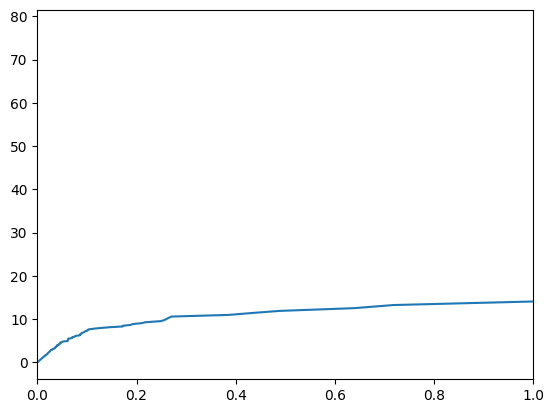

In [ ]:
# This code gives a bunch of possible alphas that can be used
path = mod_tree.cost_complexity_pruning_path(X_train_tree,y_train_tree)
ccp_alphas, MSEs = path.ccp_alphas, path.impurities
_ = plt.plot(ccp_alphas,MSEs)
_ = plt.xlim([0,1])
_ = plt

In [ ]:
# Testing with a ccp_alpha of 0.2 as given by the graph
tree_prep = DecisionTreeRegressor(ccp_alpha = 0.25)
mod_tree = tree_prep.fit(X_train_tree,y_train_tree)

in_preds = mod_tree.predict(X_train_tree)
out_preds = mod_tree.predict(X_test_tree)

print("In Sample R^2:  ",r2_score(y_train_tree,in_preds))
print("In Sample MSE:  ",mean_squared_error(y_train_tree,in_preds))
print("\nOut Sample R^2: ",r2_score(y_test_tree,out_preds))
print("Out Sample MSE: ",mean_squared_error(y_test_tree,out_preds))

In Sample R^2:   0.8769835998044013
In Sample MSE:   9.55058689967167

Out Sample R^2:  0.8355482417083389
Out Sample MSE:  12.47446364621485


In [ ]:
# Get feature importances
for i in range(len(mod_tree.feature_importances_)):
  print(X_train_tree.columns[i], mod_tree.feature_importances_[i])

Alcohol 0.004444805662677312
health_expenditure 0.0038267009901651657
HepB 0.0
Measles 0.0
BMI 0.0
Polio 0.0071624277770003875
Diphtheria 0.0
HIV 0.1968370993954874
GDP 0.00567522459137725
Population 0.0
HDI 0.7820537415832924
Schooling 0.0
Status_Developing 0.0
